In [1]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from tensorboard.backend.event_processing import event_accumulator

type = "non-iid"
# === Function to convert TF events to CSV ===
def convert_tf_to_csv(tfevent_path, save_folder):
    ea = event_accumulator.EventAccumulator(tfevent_path)
    ea.Reload()
    tags = ea.Tags()["scalars"]
    saved_files = []
    for tag in tags:
        events = ea.Scalars(tag)
        df = pd.DataFrame([(e.step, e.wall_time, e.value) for e in events],
                          columns=["step", "wall_time", "value"])
        # Scale by 100 only if ALL values are below 1
        if df['value'].max() < 1:
            df['value'] = df['value'] * 100
        filename = f"{tag.replace('/', '_')}.csv"
        save_path = os.path.join(save_folder, filename)
        df.to_csv(save_path, index=False)
        saved_files.append(save_path)
        print(f"Saved: {os.path.abspath(save_path)}")
    return saved_files

# === List of TF event files and their metadata ===
df_info = pd.read_csv(f"/Users/julian/projects/University/Period5/FederatedLearning-SNN/{type}.csv")  # must have columns: filepath, folder, aggregation, method, num_clients
tf_event_files = []
for _, row in df_info.iterrows():
    folder = os.path.dirname(row["filepath"])
    filename = os.path.basename(row["filepath"])
    tf_event_files.append((folder, filename, row["aggregation"], row["method"], row["num_clients"]))

print("Starting TF event to CSV conversion...")

for folder, filename, agg, method, n_clients in tf_event_files:
    os.makedirs(folder, exist_ok=True)
    full_path = os.path.join(folder, filename) 
    convert_tf_to_csv(full_path, folder)
print("Conversion done. Waiting 15 seconds before proceeding...")
for remaining in range(15, 0, -1):
    print(f"Continuing in {remaining} seconds...", end='\r')
    time.sleep(1)
print("Proceeding with plotting.\n")

# === Now read the CSV paths and metadata from a file (or build it here) ===
# You can replace this with your actual 'plot_path.csv' reading

# For demo, build dataframe manually from converted CSVs
all_csv_files = []
all_metadata = []

for folder, filename, agg, method, n_clients in tf_event_files:
    # List all CSVs generated in the folder after conversion
    files = [f for f in os.listdir(folder) if f.endswith("centralized_accuracy.csv") or f.endswith("Acc_train.csv")]
    for f in files:
        all_csv_files.append(os.path.join(folder, f))
        all_metadata.append({
            "filepath": os.path.join(folder, f),
            "aggregation": agg,
            "method": method,
            "num_clients": n_clients
        })

    print(files)

Starting TF event to CSV conversion...
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedavg/centralized_accuracy.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedavg/distributed_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedavg/centralized_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedprox/centralized_accuracy.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedprox/distributed_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedprox/centralized_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/federated_ser

    step     wall_time      value aggregation     method  num_clients
0      0  1.749575e+09  10.220000      FedAvg  Eventprop            5
1      1  1.749575e+09  30.290001      FedAvg  Eventprop            5
2      2  1.749575e+09  75.580002      FedAvg  Eventprop            5
3      3  1.749575e+09  74.570000      FedAvg  Eventprop            5
4      4  1.749575e+09  64.510002      FedAvg  Eventprop            5
..   ...           ...        ...         ...        ...          ...
81     6  1.749478e+09  93.888450     FedProx         SG            5
82     7  1.749478e+09  94.679588     FedProx         SG            5
83     8  1.749478e+09  95.104825     FedProx         SG            5
84     9  1.749478e+09  95.490509     FedProx         SG            5
85    10  1.749478e+09  95.599288     FedProx         SG            5

[86 rows x 6 columns]
Saved: plots/non-iid_5clients.png


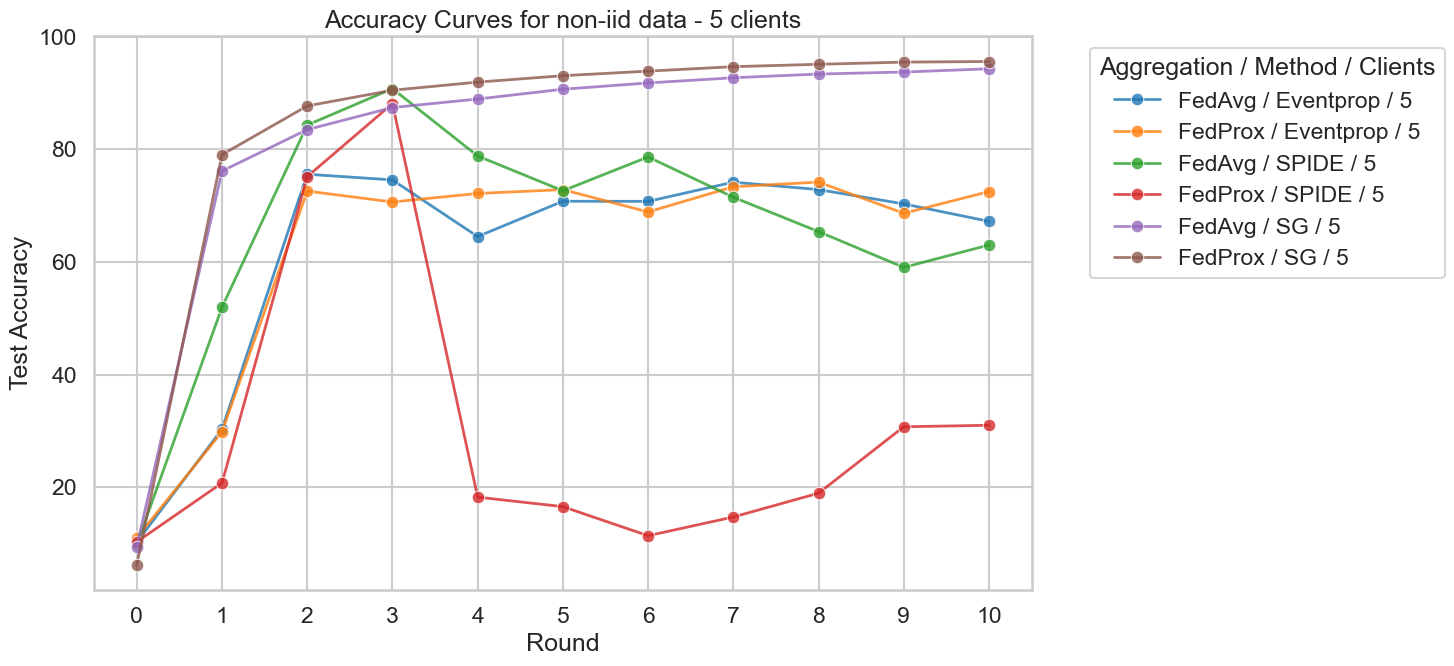

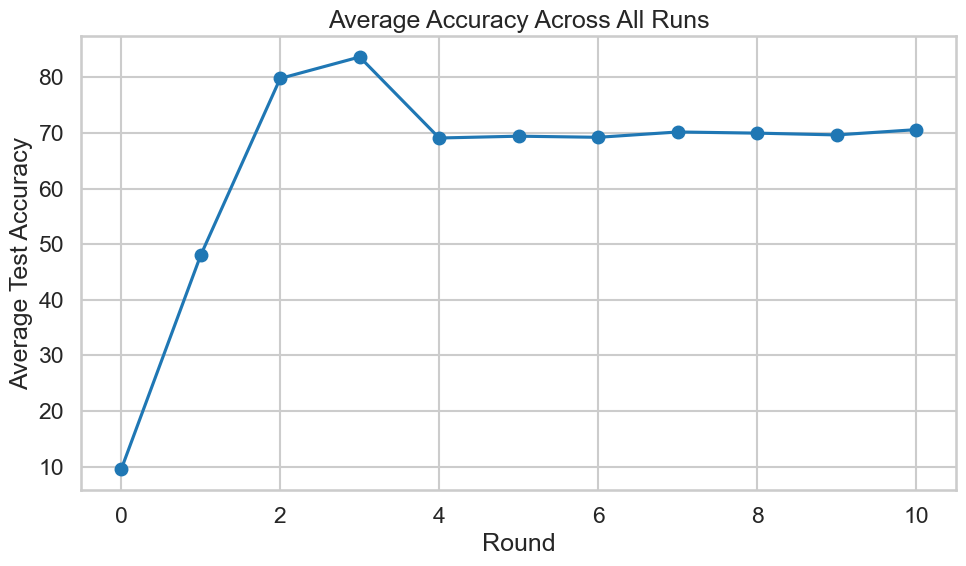

In [5]:
df_meta = pd.DataFrame(all_metadata)

# --- Load CSV data and assign metadata ---
all_dfs = []
for idx, row in df_meta.iterrows():
    try:
        df = pd.read_csv(row['filepath'], encoding='latin1')
        df['aggregation'] = row['aggregation']
        df['method'] = row['method']
        df['num_clients'] = row['num_clients']
        all_dfs.append(df)
    except Exception as e:
        print(f"Skipping {row['filepath']} due to error: {e}")

combined_df = pd.concat(all_dfs, ignore_index=True)

# --- Plot all accuracy curves ---
sns.set(style="whitegrid", context="talk", palette="colorblind")

print(combined_df)
combined_df['label'] = combined_df.apply(
    lambda row: f"{row['aggregation']} / {row['method']} / {row['num_clients']}", axis=1
)

combined_df_small = combined_df[combined_df['step'] <= 10]

# Create plots folder
plots_folder = "plots"
os.makedirs(plots_folder, exist_ok=True)

# Get unique number of clients
unique_clients = combined_df['num_clients'].unique()

for n_clients in unique_clients:
    # Filter data for this number of clients
    client_df = combined_df[combined_df['num_clients'] == n_clients]
    client_df_small = client_df[client_df['step'] <= 10]
    
    plt.figure(figsize=(15, 7))
    sns.lineplot(
        data=client_df_small,
        x='step', y='value',
        hue='label',
        palette='tab10',
        estimator=None,
        alpha=0.8,
        linewidth=2,
        marker='o'
    )
    plt.title(f"Accuracy Curves for {type} data - {n_clients} clients")
    plt.xlabel("Round")
    plt.ylabel("Test Accuracy")
    plt.legend(title="Aggregation / Method / Clients", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.xlim(-0.5, 10.5)
    plt.xticks(range(11))
    
    # Save plot
    filename = f"{type}_{n_clients}clients.png"
    filepath = os.path.join(plots_folder, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()

# --- Plot average accuracy over all runs combined (single curve) ---
avg_df = combined_df[combined_df['step'] <= 10].groupby('step', as_index=False)['value'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_df['step'], avg_df['value'], marker='o', color='tab:blue')
plt.title("Average Accuracy Across All Runs")
plt.xlabel("Round")
plt.ylabel("Average Test Accuracy")
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

Processing iid data for comparison...
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/federated_server/iid/network-SNN_Models.Spide.SNNSPIDEConvNet_num_clients-5_seed-42/centralized_accuracy.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/federated_server/iid/network-SNN_Models.Spide.SNNSPIDEConvNet_num_clients-5_seed-42/distributed_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/federated_server/iid/network-SNN_Models.Spide.SNNSPIDEConvNet_num_clients-5_seed-42/centralized_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/federated_server/iid/network-SNN_Models.Spide.SNNSPIDEConvNet_num_clients-10_seed-42/centralized_accuracy.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/federated_server/iid/network-SNN_Models.Spide.SNNSPIDEConvNet_num_clients-10_seed-42/distributed_loss.csv
Sa

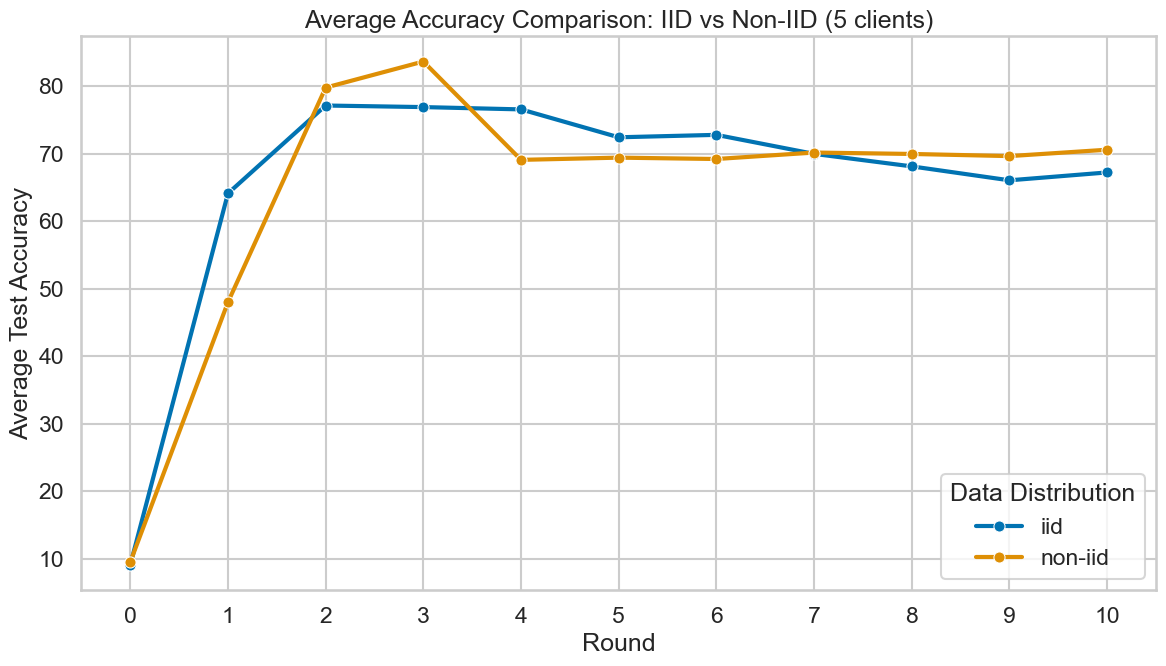

In [10]:

# === New cell: IID vs Non-IID Comparison ===
data_types = ["iid", "non-iid"]
all_avg_dfs = []

for data_type in data_types:
    print(f"Processing {data_type} data for comparison...")

    # Read metadata CSV
    df_info = pd.read_csv(f"/Users/julian/projects/University/Period5/FederatedLearning-SNN/{data_type}.csv")

    # Convert TF events to CSV
    tf_event_files = []
    for _, row in df_info.iterrows():
        folder = os.path.dirname(row["filepath"])
        filename = os.path.basename(row["filepath"])
        tf_event_files.append((folder, filename, row["aggregation"], row["method"], row["num_clients"]))

    for folder, filename, agg, method, n_clients in tf_event_files:
        os.makedirs(folder, exist_ok=True)
        full_path = os.path.join(folder, filename)
        convert_tf_to_csv(full_path, folder)

    # Build metadata for converted CSVs
    all_metadata = []
    for folder, filename, agg, method, n_clients in tf_event_files:
        files = [f for f in os.listdir(folder) if f.endswith("centralized_accuracy.csv") or f.endswith("Acc_train.csv")]
        for f in files:
            all_metadata.append({
                "filepath": os.path.join(folder, f),
                "aggregation": agg,
                "method": method,
                "num_clients": n_clients
            })

    df_meta = pd.DataFrame(all_metadata)

    # Load CSV data
    all_dfs = []
    for idx, row in df_meta.iterrows():
        try:
            df = pd.read_csv(row['filepath'], encoding='latin1')
            df['aggregation'] = row['aggregation']
            df['method'] = row['method']
            df['num_clients'] = row['num_clients']
            all_dfs.append(df)
        except Exception as e:
            print(f"Skipping {row['filepath']} due to error: {e}")

    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)

        # Filter to 5 clients and first 10 steps
        filtered_df = combined_df[
            (combined_df['num_clients'] == 5) &
            (combined_df['step'] <= 10)
        ]

        # Calculate average across all experiments for this data type
        if not filtered_df.empty:
            avg_df = filtered_df.groupby('step', as_index=False)['value'].mean()
            avg_df['data_type'] = data_type
            all_avg_dfs.append(avg_df)
            print(f"Added {data_type} average with {len(avg_df)} points")

# Create comparison plot
if len(all_avg_dfs) >= 2:
    all_data = []
    for data_type in data_types:
        df_info = pd.read_csv(f"/Users/julian/projects/University/Period5/FederatedLearning-SNN/{data_type}.csv")
        # Get unique combinations for this data type
        combos = set(df_info[df_info['num_clients'] == 5][['aggregation', 'method']].apply(tuple, axis=1))
        all_data.append((data_type, combos))

    # Find intersection
    iid_combos = all_data[0][1] if all_data[0][0] == 'iid' else all_data[1][1]
    non_iid_combos = all_data[1][1] if all_data[1][0] == 'non-iid' else all_data[0][1]
    intersecting_combos = iid_combos.intersection(non_iid_combos)

    print(f"IID combinations: {iid_combos}")
    print(f"Non-IID combinations: {non_iid_combos}")
    print(f"Intersecting combinations: {intersecting_combos}")

    comparison_df = pd.concat(all_avg_dfs, ignore_index=True)

    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=comparison_df,
        x='step', y='value',
        hue='data_type',
        marker='o',
        linewidth=3,
        markersize=8
    )
    plt.title("Average Accuracy Comparison: IID vs Non-IID (5 clients)")
    plt.xlabel("Round")
    plt.ylabel("Average Test Accuracy")
    plt.legend(title="Data Distribution")
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.xlim(-0.5, 10.5)
    plt.xticks(range(11))
    plt.tight_layout()

    # Save comparison plot
    comparison_filepath = os.path.join(plots_folder, "iid_vs_non-iid_comparison.png")
    plt.savefig(comparison_filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {comparison_filepath}")
    plt.show()
else:
    print("Not enough data types to create comparison plot")